In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [20]:
df = pd.read_csv("updated_pollution_dataset.csv")
df
max_values = df.max(numeric_only=True)
print(max_values)

Temperature                       58.60
Humidity                         128.10
PM2.5                            295.00
PM10                             315.80
NO2                               64.90
SO2                               44.90
CO                                 3.72
Proximity_to_Industrial_Areas     25.80
Population_Density               957.00
dtype: float64


In [21]:
min_values = df.min(numeric_only=True)
print(min_values)

Temperature                       13.40
Humidity                          36.00
PM2.5                              0.00
PM10                              -0.20
NO2                                7.40
SO2                               -6.20
CO                                 0.65
Proximity_to_Industrial_Areas      2.50
Population_Density               188.00
dtype: float64


#Preprocessing Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [6]:
df["Air Quality"].value_counts()

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

In [7]:
label_mappings = {}

for col in df.select_dtypes(include="object"):
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

for col, mapping in label_mappings.items():
  print(f"Mapping for column '{col}': ")
  for label, code in mapping.items():
    print(f"  {label} -> {code}")

Mapping for column 'Air Quality': 
  Good -> 0
  Hazardous -> 1
  Moderate -> 2
  Poor -> 3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   int32  
dtypes: float64(8), int32(1), int64(1)
memory usage: 371.2 KB


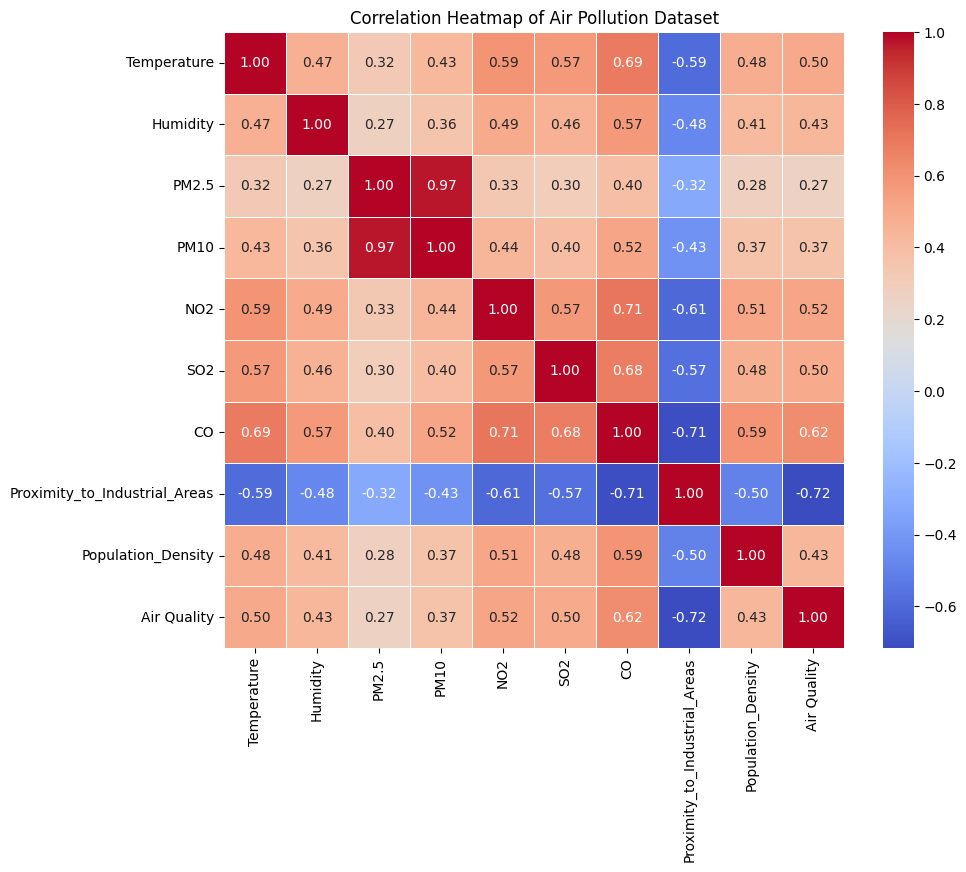

In [9]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Air Pollution Dataset')
plt.show()

#Set Up Dataset

In [10]:
X = df.drop("Air Quality", axis = 1)
y = df["Air Quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Random Forest Model

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': range(1,11),
    'min_samples_split': range(1,11)
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
250 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-pack

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400}
Best Score: 0.9550000000000001


In [12]:
rf_model = RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf,  target_names=le.classes_))

Random Forest Classification Report:
               precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.92      0.86      0.89       111
    Moderate       0.97      0.97      0.97       294
        Poor       0.88      0.90      0.89       186

    accuracy                           0.96      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.96      0.96      0.96      1000



#XGBoost Model

In [13]:
param_grid = {
    'max_depth': range(1,11),
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\SEMESTER 4\Natural Language Processing\environments\nlp\lib\site-packages\xgboost\training.py:183: UserWarning: [22:08:08] W

Best parameters: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 700}
Best Score: 0.9564999999999999


Berdasarkan GridSearchCV, parameter terbaik untuk XGBoost adalah
- n_estimators: 700
- max_depth: 1
- learning_rate: 0.08

Tapi mempertimbangkan max_depth yang terlalu small, maka max_depth dinaikkan hingga 5 dan terbukti memberikan hasil yang lebih bagus

In [ ]:
xgb_model = XGBClassifier(n_estimators=700, max_depth=5, learning_rate=0.08, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

[0]	validation_0-mlogloss:1.25581
[1]	validation_0-mlogloss:1.14477
[2]	validation_0-mlogloss:1.04909
[3]	validation_0-mlogloss:0.96602
[4]	validation_0-mlogloss:0.89266
[5]	validation_0-mlogloss:0.82742
[6]	validation_0-mlogloss:0.76899
[7]	validation_0-mlogloss:0.71741
[8]	validation_0-mlogloss:0.67114
[9]	validation_0-mlogloss:0.62931
[10]	validation_0-mlogloss:0.59119
[11]	validation_0-mlogloss:0.55601
[12]	validation_0-mlogloss:0.52427
[13]	validation_0-mlogloss:0.49561
[14]	validation_0-mlogloss:0.46853
[15]	validation_0-mlogloss:0.44413
[16]	validation_0-mlogloss:0.42117
[17]	validation_0-mlogloss:0.40055
[18]	validation_0-mlogloss:0.38077
[19]	validation_0-mlogloss:0.36337
[20]	validation_0-mlogloss:0.34691
[21]	validation_0-mlogloss:0.33194
[22]	validation_0-mlogloss:0.31792
[23]	validation_0-mlogloss:0.30540
[24]	validation_0-mlogloss:0.29378
[25]	validation_0-mlogloss:0.28267
[26]	validation_0-mlogloss:0.27268
[27]	validation_0-mlogloss:0.26327
[28]	validation_0-mlogloss:0.2

#Ensemble Model

In [15]:
voting_model= VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting="soft"
)

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting, target_names=le.classes_))

Voting Classifier Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.94      0.91      0.93       111
    Moderate       0.97      0.97      0.97       294
        Poor       0.90      0.92      0.91       186

    accuracy                           0.96      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.97      0.96      0.97      1000



Testing for best weight



In [16]:
weights = [(2,1), (1,3), (2.5,1.5), (2.5,1.5)]

for w in weights:
    ensemble = VotingClassifier(
        estimators=[('rf', rf_model), ('xgb', xgb_model)],
        voting='soft',
        weights=w
    )
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    print(f"Weights: {w}")
    print(classification_report(y_test, preds))

Weights: (2, 1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.94      0.91      0.92       111
           2       0.97      0.97      0.97       294
           3       0.90      0.92      0.91       186

    accuracy                           0.97      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.97      0.97      0.97      1000

Weights: (1, 3)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.94      0.91      0.93       111
           2       0.97      0.96      0.97       294
           3       0.90      0.92      0.91       186

    accuracy                           0.96      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.97      0.96      0.97      1000

Weights: (2.5, 1.5)
              precision    recall  f1-score   support

           0       1.00

In [17]:
weight_model = VotingClassifier(
    estimators=[
      ('rf', rf_model), ('xgb', xgb_model)
    ],
    voting='soft',
    weights=(2, 1)
)

weight_model.fit(X_train, y_train)
y_pred_weight = weight_model.predict(X_test)

print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_weight, target_names=le.classes_))

Voting Classifier Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       409
   Hazardous       0.94      0.91      0.92       111
    Moderate       0.97      0.97      0.97       294
        Poor       0.90      0.92      0.91       186

    accuracy                           0.97      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.97      0.97      0.97      1000



In [1]:
print("Masukkan data di daerah Anda untuk prediksi kualitas udara:")
temperature = float(input("Temperature (°C): "))
humidity = float(input("Humidity (%): "))
pm25 = float(input("PM2.5 (μg/m³): "))
pm10 = float(input("PM10 (μg/m³): "))
no2 = float(input("NO2 (ppb): "))
so2 = float(input("SO2 (ppb): "))
co = float(input("CO (ppm): "))
proximity_industrial = float(input("Proximity to Industrial Area (km): "))
population_density = float(input("Population Density (per km²): "))

user_input = np.array([[temperature, humidity, pm25, pm10, no2, so2, co, proximity_industrial, population_density]])

weight_pred = weight_model.predict(user_input)[0]
weight_label = le.inverse_transform([weight_pred])[0]

print("\n--- Prediksi Kualitas Udara ---")
print(f"Air Quality Prediction  : {weight_label}")

Masukkan data di daerah Anda untuk prediksi kualitas udara:


NameError: name 'np' is not defined

In [19]:
import joblib

# Save the model and the label encoder
joblib.dump(weight_model, 'air_quality_model.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']